<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/reports/TemplateFetchDatasettePages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis

<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

Deomnstrate fetching bulk data from the Datasette instance where multiple pages are returned; e.g. https://collection-analysis.cincy.pl/current_collection/item_view?checkout_total__exact=0&creation_date__gte=2021-03-01&creation_date__lte=2021-09-01&item_format__notin=Downloadable+Audiobook%2C+Downloadable+Book%2C+Downloadable+Video%2C+Downloadable+Music%2C+Web+Document%2C+Rare+Book

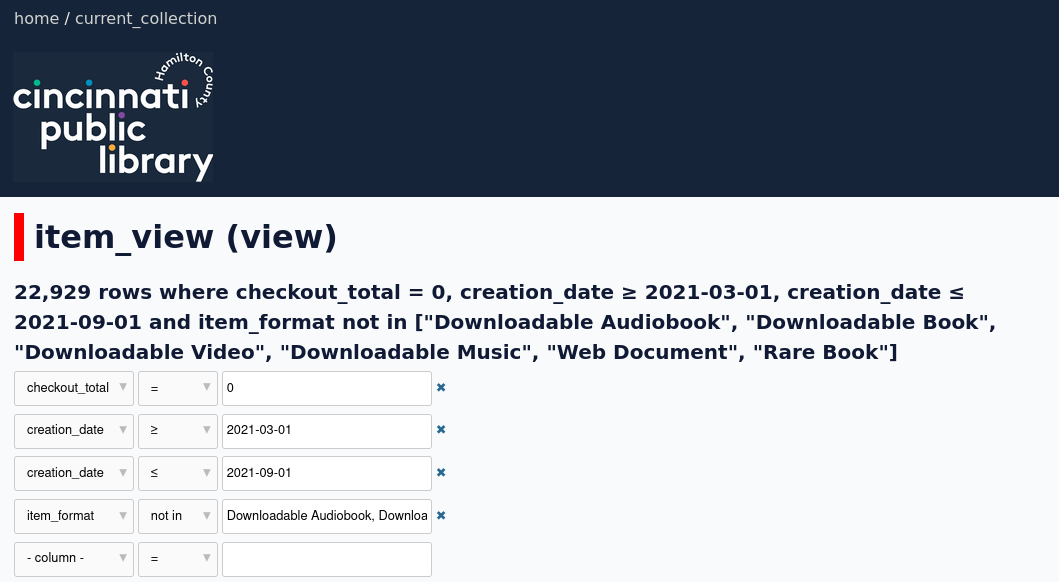

Data sources

* https://collection-analysis.cincy.pl/

In [1]:
!pip install -U rich > /dev/null
!pip install -U sqlite-utils > /dev/null

from datetime import datetime, timedelta

from rich.progress import track
from rich import print

from time import sleep

import requests
from requests.exceptions import HTTPError
from requests.adapters import HTTPAdapter, Retry

from sqlite_utils import Database

base_url = 'https://collection-analysis.cincy.pl/current_collection'

# for this example, we're going to be constructing the query such that we want 
# to consider an item create-date range age between 1 year and 6 months old
date_now = datetime.utcnow().strftime('%Y-%m-%d')
date_minus_1yr = (datetime.utcnow() - timedelta(weeks=52)).strftime('%Y-%m-%d')
date_minus_6mo = (datetime.utcnow() - timedelta(weeks=26)).strftime('%Y-%m-%d')

# print(date_now, date_minus_1yr, date_minus_6mo, sep=', ')

# allows us to add the HTTPAdapter configuration below
s = requests.Session()

retries = Retry(
    total=5,
    backoff_factor=1,
    status_forcelist=[502, 503, 504]
)

# https://stackoverflow.com/questions/50939418/what-is-the-purpose-of-mounting-a-session-object
s.mount('https://', HTTPAdapter(max_retries=retries))

url = f"""\
https://collection-analysis.cincy.pl/current_collection\
/item_view.json?\
&checkout_total__exact=0\
&creation_date__gte={date_minus_1yr}\
&creation_date__lte={date_minus_6mo}\
&item_format__notin=Downloadable+Audiobook%2C+Downloadable+Book%2C+Downloadable+Video%2C+Downloadable+Music%2C+Web+Document%2C+Rare+Book\
"""
# .format(date_minus_1yr, '2021-09-01')
print(url, "\n")

# create the sqlite db from the sqlite-utils module's Database object
db = Database("output.db", recreate=True)
db.enable_wal()

# get the first set of results ...
results = s.get(url=url)
row_count = results.json()['filtered_table_rows_count']
next_url = results.json()['next_url']
next_size = results.json()['next']

# insert results into db ...
for i, row in enumerate(results.json()['rows']):
  db["results"].insert(
      dict(
          zip(
              results.json()['columns'],
              row
          )
      )
  )

# loop, get results, insert into db
# remember that we got 1 set of results already
for n in track(range(int(next_size), row_count, int(next_size)), description="reticulating splines..."):
  if next_url is not None:
    results = s.get(url=next_url)
    row_count = results.json()['filtered_table_rows_count']

    for row in results.json()['rows']:
      db["results"].insert(
          dict(
              zip(
                  results.json()['columns'],
                  row
              )
          )
      )

      next_url = results.json()['next_url']

https://collection-analysis.cincy.pl/current_collection/item_view.json?&checkout_total__exact
=0&creation_date__gte=2021-03-12&creation_date__lte=2021-09-10&item_format__notin=Downloadabl
e+Audiobook%2C+Downloadable+Book%2C+Downloadable+Video%2C+Downloadable+Music%2C+Web+Document%
2C+Rare+Book

Output()

In [3]:
for row in db.query("select count(*) from results"):
    print(row)

for i, row in enumerate(db.query("select * from results limit 2")):
    print(i, row)

{'count(*)': 22800}

0
{
    'item_record_num': 11091993,
    'volume_record_num': 1514526,
    'bib_record_num': 1023934,
    'creation_date': '2021-03-12',
    'barcode': 'A000071181277',
    'item_format': 'Magazine',
    'location_code': '2mamh',
    'location_name': 'Main - North - Magazines & Newspapers - Circulating Issues',
    'branch_name': 'Main Library',
    'item_callnumber': 'periodical',
    'vol_statement': 'V. 92 NO. 2 Mar 2021',
    'best_author': '',
    'best_title': 'Interior design.',
    'agency_code_num': 1,
    'item_status_code': '-',
    'item_status_name': 'CHECK SHELVES',
    'last_circ_act_date': None,
    'checkout_date': None,
    'due_date': None,
    'checkout_total': 0,
    'renewal_total': 0,
    'item_price': 5.0,
    'publish_year': 999
}

1
{
    'item_record_num': 11091994,
    'volume_record_num': 1514526,
    'bib_record_num': 1023934,
    'creation_date': '2021-03-12',
    'barcode': 'A000071181301',
    'item_format': 'Magazine',
    'location_code': 'bhamg',
    'location_name': 'Bond Hill Adult Magazines',
    'branch_name': 'Bond Hill',
    'item_callnumber': 'periodical',
    'vol_statement': 'V. 92 NO. 2 Mar 2021',
    'best_author': '',
    'best_title': 'Interior design.',
    'agency_code_num': 5,
    'item_status_code': 'w',
    'item_status_name': 'WITHDRAWN',
    'last_circ_act_date': None,
    'checkout_date': None,
    'due_date': None,
    'checkout_total': 0,
    'renewal_total': 0,
    'item_price': 0.0,
    'publish_year': 999
}